# Download data

In [1]:
import requests
from tqdm import tqdm
import os
import argparse

def check_if_file_exits(file):
    """ Checks if the file specified is downloaded or not.
    Parameters:
        file(str): Name of the file to be checked.
    Returns: None
    """
    extension = file[-3:]
    file = file[:-4] + '_done.'+extension
    return True if os.path.isfile(file) else False


def download_file(url, path):
    """ Download the file in url to the path specified.
    Parameters:
        url(str): URL of the file to be downloaded.
        path(str): Destination where the downloaded file will be saved.
    Returns: None
    """
    # Check if file already exists.
    if check_if_file_exits(path):
        print(f'Already existing file {path}')
        return

    # Deleting the partial downloaded file.
    if os.path.isfile(path):
        print(f'Deleted existing partial file {path}')
        os.remove(path)

    response = requests.get(url, stream=True)
    handle = open(path, "wb")
    with open(path, "wb") as handle:
        chunk_size = 1024
        total_size = round(int(response.headers['Content-Length']), 3)
        pbar = tqdm(unit="B", total=total_size)
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:  # filter out keep-alive new chunks
                handle.write(chunk)
                pbar.update(len(chunk))

    # Marking the file as downloaded.
    extension = path[-3:]
    os.rename(path, path[:-4]+'_done.'+extension)


def make_folder(target_folder):
    """Creates folder if there is no folder in the specified path.
    Parameters:
        target_folder(str): path of the folder which needs to be created.
    Returns: None
    """
    if not (os.path.isdir(target_folder)):
        print(f'Creating {target_folder} folder')
        os.mkdir(target_folder)


def clear_screen():
    """Clears the console screen irrespective of os used"""
    import platform
    if platform.system() == 'Windows':
        os.system('cls')
        return
    os.system('clear')


def main():
    # URL of the dataset used.
    dataset_urls = ['https://ndownloader.figshare.com/files/3381290',
                    'https://ndownloader.figshare.com/files/3381296',
                    'https://ndownloader.figshare.com/files/3381293',
                    'https://ndownloader.figshare.com/files/3381302']

    # URL of dataset README
    dataset_readme = 'https://ndownloader.figshare.com/files/7953679'

    target_folder = 'dataset'
    dataset_part = 1
    dataset_file_name = f'brain_tumor_dataset_part_'

    clear_screen()
    make_folder(target_folder)

    print(f'\n\tDownloading dataset README.txt')
    download_file(dataset_readme, os.path.join(target_folder, 'README.TXT'))

    print('\n\tStarting download process\n')
    for url in dataset_urls:
        try:
            path = os.path.join(
                target_folder, f'{dataset_file_name}{dataset_part}.zip')
            print(f'\t\tDownloading :  {path}')
            download_file(url, path)
            dataset_part += 1
        except KeyboardInterrupt:
            print('\t\t\n\nDownload stopped')
            break


if __name__ == "__main__":
    main()

Creating dataset folder



100%|██████████| 1627/1627 [00:00<00:00, 1243691.02B/s]



	Starting download process



100%|██████████| 214401279/214401279 [00:44<00:00, 4831917.32B/s]


100%|██████████| 217848429/217848429 [00:26<00:00, 8260509.79B/s] 


100%|██████████| 215563856/215563856 [00:04<00:00, 53085602.78B/s]


100%|██████████| 231679762/231679762 [00:29<00:00, 7861096.34B/s] 


# Extract zips

In [8]:
import zipfile
import os

# Paths to zip files
zip_files = [
    "./dataset/brain_tumor_dataset_part_1_done.zip",
    "./dataset/brain_tumor_dataset_part_2_done.zip",
    "./dataset/brain_tumor_dataset_part_3_done.zip",
    "./dataset/brain_tumor_dataset_part_4_done.zip"
]

# Output directory
output_dir = "./dataset/mat_dataset"
os.makedirs(output_dir, exist_ok=True)

# Extract each zip file and delete it afterwards
for zip_path in zip_files:
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
            print(f"Extracted {zip_path} to {output_dir}")

        # Delete the zip file after extraction
        os.remove(zip_path)
        print(f"Deleted {zip_path}")
    else:
        print(f"File not found: {zip_path}")

Extracted ./dataset/brain_tumor_dataset_part_1_done.zip to ./dataset/mat_dataset
Deleted ./dataset/brain_tumor_dataset_part_1_done.zip
Extracted ./dataset/brain_tumor_dataset_part_2_done.zip to ./dataset/mat_dataset
Deleted ./dataset/brain_tumor_dataset_part_2_done.zip
Extracted ./dataset/brain_tumor_dataset_part_3_done.zip to ./dataset/mat_dataset
Deleted ./dataset/brain_tumor_dataset_part_3_done.zip
Extracted ./dataset/brain_tumor_dataset_part_4_done.zip to ./dataset/mat_dataset
Deleted ./dataset/brain_tumor_dataset_part_4_done.zip


# Visualization

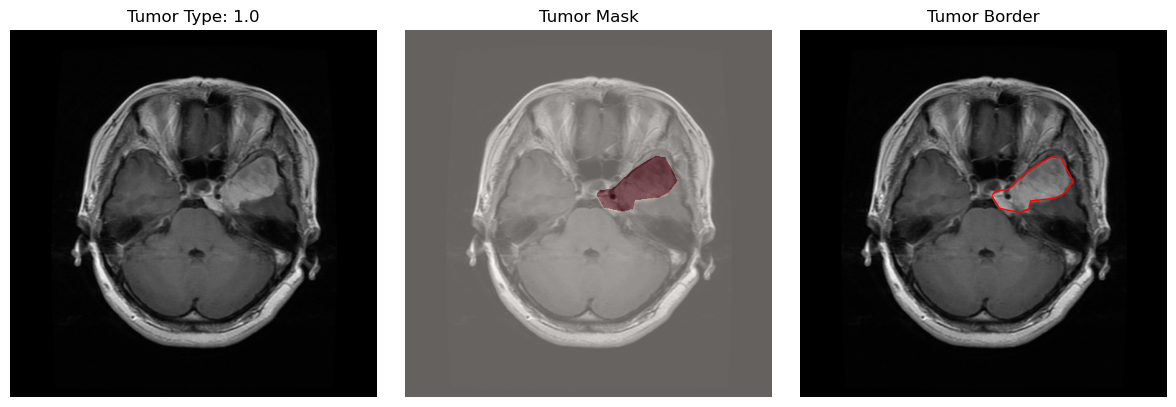

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Replace with your actual file path
file_path = './dataset/mat_dataset/1.mat'

with h5py.File(file_path, 'r') as f:
    # Helper to extract field from nested MATLAB struct
    def read_field(name):
        return f[name][()]

    # Access fields inside 'cjdata' group
    cjdata = f['cjdata']

    # Read image (transpose needed because MATLAB uses column-major order)
    image = np.array(cjdata['image']).T

    # Read tumor mask and transpose
    tumor_mask = np.array(cjdata['tumorMask']).T

    # Read label
    label = np.array(cjdata['label'])[0][0]

    # Read border vector and reshape it to (N, 2)
    border_raw = np.array(cjdata['tumorBorder'])[0]
    border_points = np.reshape(border_raw, (-1, 2))

# ✅ Visualization
plt.figure(figsize=(12, 4))

# Image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Tumor Type: {label}')
plt.axis('off')

# Tumor Mask
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.imshow(tumor_mask, alpha=0.4, cmap='Reds')
plt.title('Tumor Mask')
plt.axis('off')

# Border Overlay
plt.subplot(1, 3, 3)
plt.imshow(image, cmap='gray')
plt.plot(border_points[:, 0], border_points[:, 1], 'r-', linewidth=1)
plt.title('Tumor Border')
plt.axis('off')

plt.tight_layout()
plt.show()


# Conversion to .png format, separating images and masks

In [10]:
import h5py
import os
import numpy as np
from PIL import Image
import shutil

# Paths
mat_dir = './dataset/mat_dataset'  # Folder with .mat files
output_dir_images = './dataset/images'
output_dir_masks = './dataset/masks'
os.makedirs(output_dir_images, exist_ok=True)
os.makedirs(output_dir_masks, exist_ok=True)

# List .mat files
mat_files = sorted([f for f in os.listdir(mat_dir) if f.endswith('.mat')])

for i, file in enumerate(mat_files):
    file_path = os.path.join(mat_dir, file)

    with h5py.File(file_path, 'r') as f:
        cjdata = f['cjdata']

        # Read image and mask directly — no dereferencing!
        image = np.array(cjdata['image']).T
        tumor_mask = np.array(cjdata['tumorMask']).T

        # Normalize image for proper visualization
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min())
        image = (image * 255).astype(np.uint8)

        # Mask to binary 0–255
        mask = (tumor_mask.astype(np.uint8)) * 255

        # Save as PNGs
        image_pil = Image.fromarray(image).convert("L")
        mask_pil = Image.fromarray(mask).convert("L")

        image_pil.save(os.path.join(output_dir_images, f"{i}.png"))
        mask_pil.save(os.path.join(output_dir_masks, f"{i}_mask.png"))

        print(f"[{i+1}/{len(mat_files)}] Saved: {i}.png and {i}_mask.png")

shutil.rmtree(mat_dir)
print("✅ Extraction complete. Images saved to:", output_dir_images)


[1/3064] Saved: 0.png and 0_mask.png
[2/3064] Saved: 1.png and 1_mask.png
[3/3064] Saved: 2.png and 2_mask.png
[4/3064] Saved: 3.png and 3_mask.png
[5/3064] Saved: 4.png and 4_mask.png
[6/3064] Saved: 5.png and 5_mask.png
[7/3064] Saved: 6.png and 6_mask.png
[8/3064] Saved: 7.png and 7_mask.png
[9/3064] Saved: 8.png and 8_mask.png
[10/3064] Saved: 9.png and 9_mask.png
[11/3064] Saved: 10.png and 10_mask.png
[12/3064] Saved: 11.png and 11_mask.png
[13/3064] Saved: 12.png and 12_mask.png
[14/3064] Saved: 13.png and 13_mask.png
[15/3064] Saved: 14.png and 14_mask.png
[16/3064] Saved: 15.png and 15_mask.png
[17/3064] Saved: 16.png and 16_mask.png
[18/3064] Saved: 17.png and 17_mask.png
[19/3064] Saved: 18.png and 18_mask.png
[20/3064] Saved: 19.png and 19_mask.png
[21/3064] Saved: 20.png and 20_mask.png
[22/3064] Saved: 21.png and 21_mask.png
[23/3064] Saved: 22.png and 22_mask.png
[24/3064] Saved: 23.png and 23_mask.png
[25/3064] Saved: 24.png and 24_mask.png
[26/3064] Saved: 25.png and 2

# Check number of data (images and masks)

In [12]:
import os
images_dir = './dataset/images'
masks_dir = './dataset/masks'
imege_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.png')]
total_files_img = len(imege_files)
total_files_mask = len(mask_files)
print(f"Total images : {total_files_img}, Total masks : {total_files_mask}")

Total images : 3064, Total masks : 3064
